# Install all the requirments

In [1]:
try:
    import transformers
except:
    !pip install spacy==3.0.0
    !python -m spacy download en_core_web_sm
    !python -m spacy download es_core_news_md
    !python -m spacy download xx_sent_ud_sm
    !pip install tensorflow==2.4.1
    !pip install transformers
    !pip install tensorflow_addons
    !pip install sklearn_crfsuite 
    !pip install tqdm

In [3]:
import sys 
sys.path.append(path)

from classes.data_loader import DataLoader
from classes.utils import *
from classes.models import *
from my_eval import *
seed = 2022

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import spacy
from spacy.training import offsets_to_biluo_tags
from tqdm.auto import tqdm, trange
import spacy
import ast
import pickle
import math
from collections import defaultdict
import os
from math import ceil
from sklearn.metrics import f1_score
# %matplotlib inline

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Model params

In [8]:
PATH  = '../'
INPUT_DIRS = [PATH + 'data/task1', PATH + 'data/task2']
TEST_DIR = PATH + 'data/meddoprof_test_txt'
# TEST_DIR = None
LOADER_TYPE = 'BRAT'
labeling_scheme = 'iob'
use_dash = False
use_cls = True
lower_case = False
train_truncate_sentences = True
dev_truncate_sentences = False
tasks = ['class_ner', 'norm']
# tasks = ['SPAN', 'class', 'ner']
# tasks = ['class_ner', 'norm_1', 'norm_2', 'norm_3']
# tasks = None
learning_rate = 5e-5
max_length = 158
batch_size = 32
FRESH_DATA_LOAD = True
SAVE_DATA = False
BATCH_PADDING = True
system_name = 'bert'

# Data Loading

In [9]:
norm = pd.read_csv(PATH + 'data/task3-train.tsv', sep='\t')
# def spl(row):
#     row['start'], row['end'] = row['span'].split()
#     return row
# tqdm.pandas(desc="Splitting")
# norm = norm.progress_apply(spl, axis=1)
# norm.index = norm['filename']

In [11]:
data_loaders = {'class': DataLoader(loader_type=LOADER_TYPE, compressed=False, input_dir=INPUT_DIRS[1]),
                'ner': DataLoader(loader_type=LOADER_TYPE, compressed=False, input_dir=INPUT_DIRS[0])}
# Test 
if not TEST_DIR is None:
    test_data_loader = DataLoader(loader_type=LOADER_TYPE, compressed=False, input_dir=TEST_DIR) 

In [12]:
data = {key: data_loaders[key].load().copy() for key in data_loaders} 
# Test
if not TEST_DIR is None:
    test_data = test_data_loader.load().copy()
    test_data['SPAN'] = [sorted(ents, key=lambda abc: abc[0]) for ents in test_data['entities']]
    test_data['class'] = [sorted(ents, key=lambda abc: abc[0]) for ents in test_data['entities']]
    test_data['ner'] = [sorted(ents, key=lambda abc: abc[0]) for ents in test_data['entities']]
    test_data['norm'] = [sorted(ents, key=lambda abc: abc[0]) for ents in test_data['entities']]
    test_data['norm_1'] = [sorted(ents, key=lambda abc: abc[0]) for ents in test_data['entities']]
    test_data['norm_2'] = [sorted(ents, key=lambda abc: abc[0]) for ents in test_data['entities']]
    test_data['norm_3'] = [sorted(ents, key=lambda abc: abc[0]) for ents in test_data['entities']]
    test_data['class_ner'] = [sorted(ents, key=lambda abc: abc[0]) for ents in test_data['entities']]
    if 'norm' in test_data.columns:
        test_data['class_ner_norm'] = [sorted(ents, key=lambda abc: abc[0]) for ents in test_data['entities']]


In [13]:
data2 = data['ner'][['id', 'text']].copy()
data2['SPAN'] = None
data2['class'] = [sorted(ents, key=lambda abc: abc[0]) for ents in data['class']['entities']]
data2['ner'] = [sorted(ents, key=lambda abc: abc[0]) for ents in data['ner']['entities']]
data2['class_ner'] = data2.apply(lambda row: [(ents1[0], ents1[1], ents1[-1] + '+' + ents2[-1]) for ents1, ents2 in zip(row['class'], row['ner'])], axis=1)
data2['SPAN'] = data2['ner'].apply(lambda row: [(start, end, 'SPAN') for start, end, _ in row])
def fun(row):
    ents = [(start, end) for start, end, _ in row['ner']]
    df = norm[norm['filename'] == row['id']]
    res = {(start, end): (start, end, 'none') for start, end in ents}
    for i, row2 in df.iterrows():
        start, end = [int(x) for x in row2['span'].split()]
        if (start, end) in ents:
            res[(start, end)] = (start, end, str(row2['code']))
        else:
            for s, e in ents:
                if abs(start - s) <= 10 or abs(end - e) <= 10:
                    res[(s,e)] = (s, e, str(row2['code']))
                    break
        # start, end = [int(x) for x in row2['span'].split()]
        # if (start, end) in ents:
        #     res[(start, end)] = (start, end, str(row2['code']) + '.none' * (3 - len(row2['code'].split('.'))))
        # else:
        #     for s, e in ents:
        #         if abs(start - s) <= 10 or abs(end - e) <= 10:
        #             res[(s,e)] = (s, e, str(row2['code']) + '.none' * (3 - len(row2['code'].split('.'))))
        #             break
    res = sorted(res.values(), key=lambda abc: abc[0])
    if 'norm' in tasks or 'class_ner_norm' in tasks:
        row['norm'] = [items for items in res]
    else:
        for i in range(3):
            if i == 0:
                if 'norm_1' in tasks:
                    row['norm_%s' % (i + 1)] = [(s, e, c.split('.')[i] if  i < len(c.split('.')) else 'none') for s, e, c in res]
                else:
                    for j in range(0,4,2):
                        row['norm_%s%s' % (i + 1, j + 1)] = [(s, e, c.split('.')[i][j:j+2] if c.split('.')[i][j:j+2] and not c.split('.')[i][:4] in ['SCTI', 'none'] else 
                                                              c.split('.')[i] if j == 0 else 'none') for s, e, c in res]
                    # for j in range(4):
                    #     row['norm_%s%s' % (i + 1, j + 1)] = [(s, e, c.split('.')[i] if c.split('.')[i][:4] in ['SCTI', 'none'] else 
                    #                                           c.split('.')[i][j] if i < len(c.split('.')) and j < len(c.split('.')[i]) else 'none') for s, e, c in res]
            else:
                row['norm_%s' % (i + 1)] = [(s, e, c.split('.')[i] if  i < len(c.split('.')) else 'none') for s, e, c in res]
    return row
tqdm.pandas(desc="Merging")
data2 = data2.progress_apply(fun, axis=1)
if 'norm' in data2.columns:
    data2['class_ner_norm'] = data2.apply(lambda row: [(ents1[0], ents1[1], ents1[-1] + '+' + ents2[-1] + '+' + ents3[-1]) for ents1, ents2, ents3 in zip(row['class'], row['ner'], row['norm'])], axis=1)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version


In [14]:
unique_labels = OrderedDict()
for key in tasks:
    unique_labels[key] = sorted(list({label: None for i, row in data2.iterrows() for start, end, label in row[key]})) 
# unique_labels

In [15]:
# if not tasks is None:
#     unique_labels = {key: unique_labels[key] for key in tasks}
# unique_labels = dict(sorted(unique_labels.items(), key=lambda kv: kv[0]))
# list(unique_labels)
if tasks is None:
    tasks = list(unique_labels)

In [16]:
data = data2

In [17]:
%%time
if FRESH_DATA_LOAD:
    tqdm.pandas(desc="Splitting to sentences")
    data = data.progress_apply(lambda row: label(row, [col for col in data.columns if not col in ['id', 'text']], labeling_scheme=labeling_scheme), axis=1)

    # Test
    if not TEST_DIR is None:
        tqdm.pandas(desc="Splitting test to sentences")
        test_data = test_data.progress_apply(lambda row: label(row, [col for col in test_data.columns if not col in ['id', 'text']], labeling_scheme=labeling_scheme), axis=1)
    if SAVE_DATA:
        data.to_csv(PATH + 'data/preprocessed_data_%s.csv' % labeling_scheme, index=False)
else:
    data = pd.read_csv(PATH + 'data/preprocessed_data_%s.csv' % labeling_scheme)
    data['sents'] = data['sents'].apply(ast.literal_eval)
    for col in data.columns:
        if col.endswith('lbls'):
            data[col] = data[col].apply(ast.literal_eval)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version


/usr/local/lib/python3.7/dist-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Motivo de consulta
Paciente varón de 49 años de ed..." with entities "[(73, 90, 'SPAN'), (92, 95, 'SPAN'), (1257, 1265, ...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
/usr/local/lib/python3.7/dist-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Motivo de consulta
Paciente varón de 49 años de ed..." with entities "[[73, 90, 'SANITARIO'], [92, 95, 'SANITARIO'], [12...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
/usr/local/lib/python3.7/dist-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Motivo de consul


CPU times: user 56.2 s, sys: 1.04 s, total: 57.3 s
Wall time: 57.5 s


In [18]:
data = data[['id', 'text', 'sents'] + tasks + [t + '_lbls' for t in tasks]]

In [19]:
data['stratify'] = data[tasks[0]].apply(lambda x: min(len(x), 17))

In [20]:
data['stratify'].value_counts()

1     546
0     299
2     249
3     133
4      75
5      50
6      35
8      23
9      17
10     16
7      14
11     14
17      9
15      6
13      6
12      5
14      3
Name: stratify, dtype: int64

In [22]:
if not tasks is None:
    data = data.drop(columns=[col for col in data.columns if col.endswith('lbls') and not col[:-5] in tasks])

In [23]:
from sklearn.model_selection import train_test_split
train_data, dev_data = train_test_split(data, test_size=0.2, random_state=seed, stratify=data['stratify'])

In [24]:
# Test
if not TEST_DIR is None:
    dev_data = test_data

# BERT configurations

In [25]:
import transformers
from transformers import AutoConfig, AutoModel, AutoTokenizer, BertConfig, DistilBertConfig, \
                         TFBertModel, BertTokenizerFast, DistilBertTokenizer, BatchEncoding, \
                         TFBertForTokenClassification, TFDistilBertForTokenClassification, TFDistilBertModel, \
                         RobertaConfig, RobertaTokenizer, TFRobertaForTokenClassification
from tokenizers import Encoding

In [26]:
# Bert tokenizer
# MODEL_NAME = 'bert-base-cased'
# MODEL_NAME = 'bert-base-multilingual-cased'
# MODEL_NAME = 'distilbert-base-cased'
# MODEL_NAME = 'distilbert-base-multilingual-cased'
MODEL_NAME = 'dccuchile/bert-base-spanish-wwm-cased'
# MODEL_NAME = 'mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es'
# MODEL_NAME = 'xlm-roberta-base'
# MODEL_NAME = 'roberta-base'
# MODEL_NAME = 'distilroberta-base'
if 'large' in MODEL_NAME:
    vector_size = 1024
else:
    vector_size = 768
if 'roberta' in MODEL_NAME:
#     tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
elif 'distil' in MODEL_NAME:
    tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
#     tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)
else:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [27]:
%%time
train_input = convert_to_token_level(train_data, tokenizer=tokenizer, lower_case=lower_case)
dev_input = convert_to_token_level(dev_data, tokenizer=tokenizer, lower_case=lower_case)


CPU times: user 1min 4s, sys: 799 ms, total: 1min 5s
Wall time: 1min 5s


# Data Pre-Processing

In [28]:
%%time
train_input = split_long_sentence(train_input, max_length, remove=train_truncate_sentences)
dev_input = split_long_sentence(dev_input, max_length, remove=dev_truncate_sentences)


CPU times: user 24.9 s, sys: 879 ms, total: 25.7 s
Wall time: 25.1 s


In [29]:
%%time
cols = [col for col in train_data.columns if col.endswith('lbls')]
filt = lambda s: {tuple(items[:3]): tuple(list(items)[3:]) for items in 
                                                zip(*([s["id"].tolist(), s['key'].tolist(), s["start"].tolist(), 
                                                       s["sub_tokens"].tolist(), s["end"].tolist(), s["token"].tolist()] + 
                                                      [s[col] for col in cols if tasks is None or col[:-5] in tasks]))}
tqdm.pandas(desc="Transforming")
train_sents = train_input.groupby(["id", "key"], sort=False).progress_apply(filt)
dev_sents = dev_input.groupby(["id", "key"], sort=False).progress_apply(filt)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



CPU times: user 15 s, sys: 362 ms, total: 15.4 s
Wall time: 15.5 s


In [32]:
%%time
cls_id = tokenizer(tokenizer.cls_token, add_special_tokens=False)['input_ids'][0]
sep_id = tokenizer(tokenizer.sep_token, add_special_tokens=False)['input_ids'][0]
len_cols = len([col for col in train_data.columns if col.endswith('lbls')])
def subword_labeling(i, count, x, use_dash=False):
    if use_dash:
        return x if i == 0 else '-'
        # return x if i == 0 or x == 'O' else '-'
    if labeling_scheme in ['iob', 'bio']:
        return x if i == 0 else x.replace('B-', 'I-')
    else:
        if x.startswith('U-') and count > 1:
            if i == 0:
                return x.replace('U-', 'B-')
            elif i == count - 1:
                return x.replace('U-', 'L-')
            else:
                return x.replace('U-', 'I-')
        elif x.startswith('B-'):
            return x if i == 0 else x.replace('B-', 'I-')
        elif x.startswith('L-'):
            return x if i == count - 1 else x.replace('L-', 'I-')
        return x
            
            
    

# use '-' only for entities
train_encodings = {list(sent)[0][:2]: ([(cls_id, ['O'] * len_cols)] if use_cls else []) + 
                                      [(id, [subword_labeling(i, len(sent[key][0]), x, use_dash) for x in sent[key][-len_cols:]]) 
                                                                              for key in sent for i, id in enumerate(sent[key][0])] + 
                                      ([(sep_id, ['O'] * len_cols)] if use_cls else [])
                   for sent in train_sents}
dev_encodings = {list(sent)[0][:2]: ([(cls_id, ['O'] * len_cols)] if use_cls else []) + 
                                      [(id, [subword_labeling(i, len(sent[key][0]), x, use_dash) for x in sent[key][-len_cols:]]) 
                                                                              for key in sent for i, id in enumerate(sent[key][0])] + 
                                      ([(sep_id, ['O'] * len_cols)] if use_cls else [])
                   for sent in dev_sents}
# # use '-' for every subword
# train_encodings = {list(sent)[0][:2]: [(cls_id, ['O'] * len_cols)] + 
#                                       [(id, [x if i == 0 else '-' for x in sent[key][-len_cols:]]) 
#                                                                                     for key in sent for i, id in enumerate(sent[key][0])] + 
#                                       [(sep_id, ['O'] * len_cols)] 
#                    for sent in train_sents}
# dev_encodings = {list(sent)[0][:2]: [(cls_id, ['O'] * len_cols)] + 
#                                       [(id, [x if i == 0 else '-' for x in sent[key][-len_cols:]]) 
#                                                                                     for key in sent for i, id in enumerate(sent[key][0])] + 
#                                       [(sep_id, ['O'] * len_cols)] 
#                    for sent in dev_sents}

CPU times: user 6.78 s, sys: 142 ms, total: 6.92 s
Wall time: 6.92 s


In [33]:
# train_encodings[('S1887-85712013000300006-1', 301)]

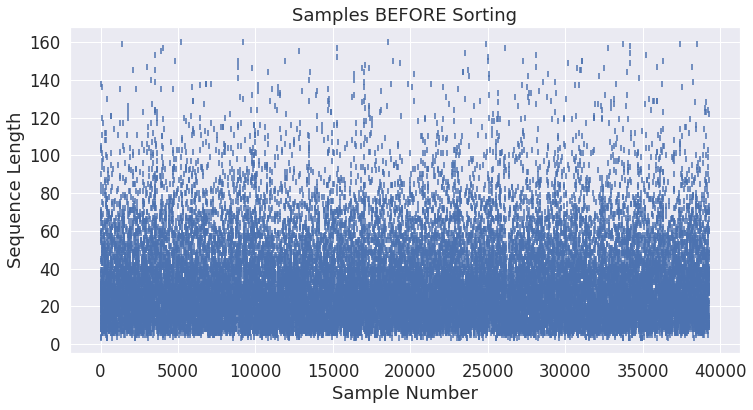

In [34]:
# plot
# Get all of the lengths.
unsorted_lengths = [len(train_encodings[key]) for key in tqdm(train_encodings)]
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()


In [35]:
# for x in train_encodings.items():
#     print(x)

In [36]:
# Sort the two lists together by the length of the input sequence.
random.seed(seed)
train_samples = list(train_encodings.items())
random.shuffle(train_samples)
train_samples = sorted(train_samples, key=lambda x: len(x[1]), reverse=True)
dev_samples = list(dev_encodings.items())
random.shuffle(dev_samples)
dev_samples = sorted(dev_samples, key=lambda x: len(x[1]), reverse=True)
sorted_train_lengths = [len(s[1]) for s in train_samples]
sorted_dev_lengths = [len(s[1]) for s in dev_samples]
print('Train Shortest sample:', len(train_samples[0][1]))
print('Train Longest sample:', len(train_samples[-1][1]))
print('Dev Shortest sample:', len(dev_samples[0][1]))
print('Dev Longest sample:', len(dev_samples[-1][1]))

Train Shortest sample: 160
Train Longest sample: 3
Dev Shortest sample: 160
Dev Longest sample: 3


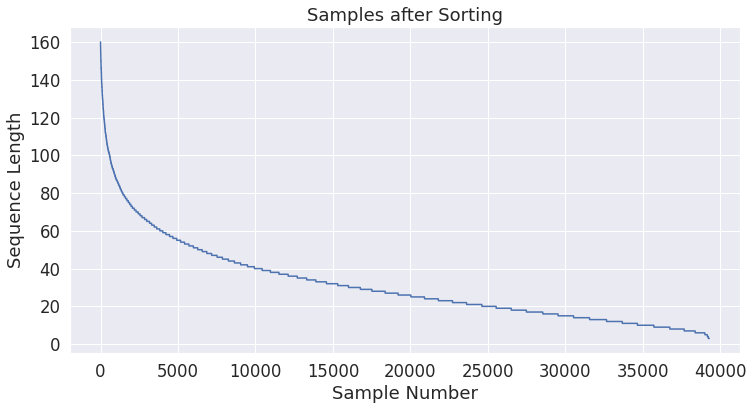

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(range(0, len(sorted_train_lengths)), sorted_train_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()


In [39]:
# %%time
pad_token = tokenizer(tokenizer.pad_token, add_special_tokens=False)['input_ids'][0]
train_batch_keys, train_batch_ids, train_batch_masks, train_batch_lbls = batching(train_samples, batch_size, extend=BATCH_PADDING, pad_token=pad_token, max_len=max_length, mix=True)
dev_batch_keys, dev_batch_ids, dev_batch_masks, dev_batch_lbls = batching(dev_samples, min(batch_size * 4, 128), extend=BATCH_PADDING, pad_token=pad_token, max_len=max_length, mix=False)

Creating batches of size 32
  Selected 0 batches.
  Selected 4,000 batches.
  Selected 8,000 batches.
  Selected 12,000 batches.
  Selected 16,000 batches.
  Selected 20,000 batches.
  Selected 24,000 batches.
  Selected 28,000 batches.
  Selected 32,000 batches.
  Selected 36,000 batches.
Creating batches of size 128


In [40]:
%%time
if not BATCH_PADDING:
    le = MyLabelEncoder(unique_labels, labeling_scheme, use_dash)
    y_train = [[le.transform(y) for y in batch] for batch in train_batch_lbls]
    # y_train = [to_categorical(y, num_classes=len(le)) for y in y_train]
    y_dev = [[le.transform(y) for y in batch] for batch in dev_batch_lbls]
    # y_dev = [to_categorical(y, num_classes=len(le)) for y in y_dev]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [41]:
if BATCH_PADDING:
    le = MyLabelEncoder(unique_labels, labeling_scheme, use_dash)
    y_train = [le.transform(y) for y in train_batch_lbls]
    y_dev = [le.transform(y) for y in dev_batch_lbls]

In [42]:
# %%time

# def gen(keys, ids, msks, ys):
#     for key, id, msk, y in zip(keys, ids, msks, ys):
#         yield (key, id, msk, y)
        
# train_ds = tf.data.Dataset.from_generator(lambda: gen(train_batch_keys, train_batch_ids, train_batch_masks, y_train), 
#                                                ((tf.string, tf.int32),tf.int32,tf.int32,tf.int32))
# train_ds_size = len(train_batch_keys)
        
# dev_ds = tf.data.Dataset.from_generator(lambda: gen(dev_batch_keys, dev_batch_ids, dev_batch_masks, y_dev), 
#                                                ((tf.string, tf.int32),tf.int32,tf.int32,tf.int32))
# dev_ds_size = len(dev_batch_keys)

In [43]:
class DataGenerator:
    def __init__(self, keys, ids, masks, ys):
        self.keys = keys
        self.ids = ids
        self.masks = masks
        self.ys = ys
        self.counter = 0
        self.n = len(self.keys)
    
    def __len__(self):
        return self.n

    def __iter__(self):
        for i in range(self.n):
            yield (tf.convert_to_tensor(self.ids[i]), 
                   tf.convert_to_tensor(self.masks[i]), tf.convert_to_tensor(self.ys[i]))
            
if not BATCH_PADDING:
    train_ds = DataGenerator(train_batch_keys, train_batch_ids, train_batch_masks, y_train)
    train_ds_size = len(train_ds)
    dev_ds = DataGenerator(dev_batch_keys, dev_batch_ids, dev_batch_masks, y_dev)
    dev_ds_size = len(dev_ds)

In [44]:
%%time
if BATCH_PADDING:
    train_dataset = tf.data.Dataset.from_generator(lambda: [(x, y, z) for x, y, z in zip(train_batch_ids, train_batch_masks, y_train)], 
                                                   (tf.int32, tf.int32, tf.int32), ([None], [None], [None, None]))
    dev_dataset = tf.data.Dataset.from_generator(lambda: [(x, y, z) for x, y, z in zip(dev_batch_ids, dev_batch_masks, y_dev)], 
                                                   (tf.int32, tf.int32, tf.int32), ([None], [None], [None, None]))

    train_ds_size = ceil(len(train_batch_ids) / batch_size)
    dev_ds_size = ceil(len(dev_batch_ids) / batch_size)
    print(train_ds_size, dev_ds_size)

    train_ds = train_dataset.padded_batch(batch_size, padded_shapes=([None], [None], [None, None]), 
                                                                     padding_values=(pad_token, 0, 1), drop_remainder=False)
    dev_ds = dev_dataset.padded_batch(batch_size, padded_shapes=([None], [None], [None, None]), 
                                                                 padding_values=(pad_token, 0, 1), drop_remainder=False)

1228 449
CPU times: user 373 ms, sys: 275 ms, total: 647 ms
Wall time: 649 ms


In [45]:
cols = [col for col in train_data.columns if col.endswith('lbls')]
filt = lambda s: [tuple(items) for items in zip(*([s["start"].tolist(), s["end"].tolist(), s["count"].tolist(), s["token"].tolist()] + 
                                                  [s[col] for col in cols]))]
tqdm.pandas(desc="Transforming")
dev_meta_data = dev_input.groupby(["id", "key"], sort=False).progress_apply(filt)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version


# Build bert classifier

In [46]:
# Bert
if 'roberta' in MODEL_NAME:
    config  = RobertaConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True, return_dict=True, use_cache=True, num_labels=len(le))
    bert_model = TFRobertaForTokenClassification.from_pretrained(MODEL_NAME, config=config)
elif 'distil' in MODEL_NAME:
    config  = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True, return_dict=True, use_cache=True, num_labels=len(le))
    bert_model = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config)
else:
    config = BertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True, return_dict=True, use_cache=True, num_labels=len(le))
    bert_model = TFBertForTokenClassification.from_pretrained(MODEL_NAME, config=config)

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
# # Compile the model
# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
# bert_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [48]:

model = BertClassifier(bert_model, max([len(le[key]) for key in le]), bert_trainable=True, le=le, tasks=tasks)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


output_dir = PATH + '/models/tf'
ckpt = tf.train.Checkpoint(optimizer=optimizer, model=model)
# ckpt.restore(tf.train.latest_checkpoint(output_dir))
ckpt_manager = tf.train.CheckpointManager(ckpt,
                                          output_dir,
                                          checkpoint_name='model.ckpt',
                                          max_to_keep=1)


@tf.function(experimental_relax_shapes=True)
def train_one_step(model, optimizer, input_ids, attention_mask, y, dont_train=None, experimental_relax_shapes=True):
    with tf.GradientTape() as tape:
        if dont_train is None:
            logits, loss, f1s = model(input_ids, attention_mask, y)
        else:
            logits, loss, f1s = model(input_ids, attention_mask, y, dont_train=dont_train)
    gradients = tape.gradient([loss[key] for key in loss], model.trainable_variables)
    # print(type(gradients), len(gradients))
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, logits, f1s
    

@tf.function(experimental_relax_shapes=True)
def predict_one_step(model, val_input_ids, val_attention_mask, val_y, dont_train=None, experimental_relax_shapes=True):
    logits, loss, f1s = model(val_input_ids, val_attention_mask, val_y, training=False, dont_train=dont_train)
    # tf.print(f1s)
    return loss, logits, f1s


# Model Unit Test

In [49]:
# Test the model
best_f1 = 0
best_loss = float("inf")
step = 0
epochs = 30
patience = 0
reduce_lr = 2
early_stop = 6
dont_train = None
# dont_train = [x for x in tasks if x.startswith('norm')]

warmup_learning_rate = learning_rate * 2
warmup_steps = 500

print(("=" * 50) + " Start testing the model " + ("=" * 50))
print(("=" * 50) + " Train 1 " + ("=" * 50))
for i, (input_ids, attention_mask, y) in enumerate(train_ds):
    loss, logits, f1s = train_one_step(model, optimizer, input_ids, attention_mask, y, dont_train=dont_train)
    if i > 5:
        break
        
# print(("=" * 50) + " Train 2 " + ("=" * 50))
# for i, (input_ids, attention_mask, y) in enumerate(train_ds):
#     loss, logits, f1s = train_one_step(model, optimizer, input_ids, attention_mask, y, dont_train=tasks[1:])
#     if i > 5:
#         break
        
print(("=" * 50) + " Inference " + ("=" * 50))
for i, (input_ids, attention_mask, y) in enumerate(dev_ds):
    loss, logits, f1s = predict_one_step(model, input_ids, attention_mask, y, dont_train=dont_train)
    loss, logits, f1s = predict_one_step(model, input_ids, attention_mask, val_y=None, dont_train=dont_train)
    if i > 10:
        break
print(("=" * 50) + " Test finished " + ("=" * 50))

================================================== Start testing the model ==================================================
================================================== Train 1 ==================================================
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else stat

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: CRF decoding models have serialization issues in TF >=2.5 . Please see isse #2476


================================================== Inference ==================================================
================================================== Test finished ==================================================


# Start training

In [50]:
%%time
# tf.config.run_functions_eagerly(False)
for epoch in range(0, epochs):
    # Test
    if not TEST_DIR is None:
        continue
    print("Training, Epoch: %s" % (epoch + 1))
    acc_loss = defaultdict(list)
    acc_f1 = defaultdict(list)
    tqdm_bar = tqdm(enumerate(train_ds), total=train_ds_size)
    for i, (input_ids, attention_mask, y) in tqdm_bar:
        step = step + 1
        loss, logits, f1s = train_one_step(model, optimizer, input_ids, attention_mask, y, dont_train=dont_train)
        for j, key in enumerate(loss):
            acc_loss[key].append(loss[key].numpy())
            acc_f1[key].append(f1s[key].numpy())
            
        # print(loss)
        if step % 10 == 0:
            all_loss = {key: round(np.average(acc_loss[key]), 5) for key in acc_loss}
            all_f1 = {key: round(np.average(acc_f1[key]), 5) for key in acc_f1}
            tqdm_bar.set_postfix({'loss': all_loss, 'f1': all_f1})
            # tqdm_bar.refresh() # to show immediately the update
        if step < warmup_steps:
            optimizer.learning_rate.assign(warmup_learning_rate * (step / warmup_steps))
        if step == warmup_steps:
            optimizer.learning_rate.assign(learning_rate)
            print("Warmup finished")
            
    eval_loss = defaultdict(list)
    eval_f1s = defaultdict(list)
    # Validation
    y_true = defaultdict(list)
    y_pred = defaultdict(list)
    gs_df = defaultdict(lambda: pd.DataFrame())
    pred_df = defaultdict(lambda: pd.DataFrame())
    print("Validating, Epoch: %s" % (epoch + 1))
    for i, (val_input_ids, val_attention_mask, val_y) in tqdm(enumerate(dev_ds), total=dev_ds_size):
        if BATCH_PADDING:
            start = i * batch_size
            dev_keys = dev_batch_keys[start:start + batch_size]
        else:
            dev_keys = dev_batch_keys[i]
        loss, logits, f1s = predict_one_step(model, val_input_ids, val_attention_mask, val_y, dont_train=dont_train)
        
        for k, key in enumerate(le):
            res = get_batch_entities(dev_keys, val_y[:,:,k].numpy(), key, use_cls, max_length, le, dev_meta_data, return_df=True)
            gs_df[key] = pd.concat([gs_df[key], res], ignore_index=False)
            # y_true[key].extend(res)
            res = get_batch_entities(dev_keys, logits[key].numpy().argmax(-1), key, use_cls, max_length, le, dev_meta_data, return_df=True)
            pred_df[key] = pd.concat([pred_df[key], res], ignore_index=False)
            # y_pred[key].extend(res)
        for key in f1s:
            eval_loss[key].append(loss[key].numpy())
            eval_f1s[key].append(f1s[key].numpy())

    # y_true_sets = {key: set(y_true[key]) for key in y_true}
    # y_pred_sets = {key: set(y_pred[key]) for key in y_pred}
    # tps = {key: len(y_true_sets[key].intersection(y_pred_sets[key])) for key in y_true_sets}
    # tp_fps = {key: len(y_pred_sets[key]) for key in y_pred_sets}
    # tp_fns = {key: len(y_true_sets[key]) for key in y_true_sets}
    # ps = {key: tps[key] / tp_fps[key] if tp_fps[key] > 0 else 0.0 for key in tps}
    # rs = {key: tps[key] / tp_fns[key] if tp_fns[key] > 0 else 0.0 for key in tps}
    # eval_f1 = {key:  (2.0 * ps[key] * rs[key]) / (ps[key] + rs[key]) if (ps[key] + rs[key]) > 0 else 0.0 for key in ps}
    
    eval_f1 = {key: my_eval(key if key in ['class', 'ner'] else 'ner' if key == 'SPAN' or 'ner' in key or 'class' in key else 'norm', 
                            gs_df[key].reset_index(drop=True), pred_df[key].reset_index(drop=True), 
                            list(dict(gs_df[key]['clinical_case'].value_counts()))) for key in le}


    all_eval_loss = {key: round(np.average(eval_loss[key]), 5) for key in eval_loss}
    all_eval_f1 = {key: round(eval_f1[key], 5) for key in eval_f1}
    print('loss: %s, f1: %s' % (all_eval_loss, all_eval_f1))
    f1 = np.average([eval_f1[key] for key in eval_f1])
    # lss = np.average([np.average(eval_loss[key]) for key in eval_loss])
    # f1 = eval_f1[tasks[0]]
    lss = np.average([eval_loss[tasks[0]] for key in eval_loss])
    if f1 > best_f1:
        best_f1 = f1
        best_loss = lss
        ckpt_manager.save()
        print("Model have been saved!, loss: %s, f1: %s." % (lss, f1))
        # print(eval_f1)
        # print(best_f1)
        patience = 0
    else:
        patience += 1
    if (patience != 0 and patience % reduce_lr == 0):
        last_learning_rate = float(optimizer.learning_rate)
        optimizer.learning_rate.assign(last_learning_rate * 0.5)
        print("Reduce learning rate from %0.6f to %0.6f" % (last_learning_rate, optimizer.learning_rate))
        print(patience)
    if patience >= early_stop:
        break
    print("=" * 120)
    

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 11.7 µs


In [51]:
best_f1, best_loss

(0, inf)

In [52]:
if best_f1 > 0:
    output_dir = PATH + 'models/tf_overfitted'
    ckpt = tf.train.Checkpoint(optimizer=optimizer, model=model)
    ckpt_manager = tf.train.CheckpointManager(ckpt,
                                            output_dir,
                                            checkpoint_name='model.ckpt',
                                            max_to_keep=1)
    ckpt_manager.save()

In [53]:
# restore model
output_dir = PATH + 'models/tf'
ckpt = tf.train.Checkpoint(optimizer=optimizer, model=model)
ckpt.restore(tf.train.latest_checkpoint(output_dir))

# Predict

In [54]:
to_be_saved = defaultdict(lambda : defaultdict(list))
from tqdm.auto import tqdm, trange
for i, (input_ids, attention_mask, y) in tqdm(enumerate(dev_ds), total=dev_ds_size):
    if BATCH_PADDING:
        start = i * batch_size
        keys = dev_batch_keys[start:start + batch_size]
    else:
        keys = dev_batch_keys[i]
    loss, res, f1s = predict_one_step(model, input_ids, attention_mask, val_y=None)
    for label in list(le):
        to_be_saved = get_batch_entities(keys, res[label].numpy().argmax(-1), label, use_cls, max_length, le, dev_meta_data, to_be_saved=to_be_saved)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: CRF decoding models have serialization issues in TF >=2.5 . Please see isse #2476


# Export the results

In [65]:
import shutil
# TEST
local_path = '/' if TEST_DIR is None else PATH + 'output_stratify_2022_bs_158_classner_norm_dccuchile/'
columns = ['filename', 'text', 'span', 'code']
def save_output(to_be_saved, columns, local_path, part=0):
    out_df = None
    dfs = {}
    for label in list(le):
        data = []
        if label in ['ner', 'class', 'class_ner', 'class_ner_norm'] and part != 2:

            file_path1 = local_path + 'output/bert/%s/predict/' % label.split('_')[part]
            file_path2 = local_path + 'output/bert/%s/original/' % label.split('_')[part]
            try: shutil.rmtree(file_path1) 
            except: pass
            try: shutil.rmtree(file_path2) 
            except: pass
            try: 
            os.makedirs(file_path1)
            except: 
            pass
            try: 
            os.makedirs(file_path2)
            except: 
            pass
            output = to_be_saved[label]
            for file in tqdm(output):
                with open(file_path1 + (str(file) + '.ann'), 'wb') as f:
                    output[file] = sorted(output[file], key=lambda line: line[2])
                    try:
                        f.write(('\n'.join([line[0] % (i + 1) + '\t' + 
                                          line[1].split('+')[part] + ' ' + str(line[2]) + ' ' + str(line[3]) + '\t' + 
                                          line[4] for i, line in enumerate(output[file])])).encode())
                    except Exception as ex:
                        print(ex)
                    file_name = file + '.ann'
                task = 'task1' if label == 'ner' or 'ner' in label and part == 1 else 'task2'
                # if not TEST_DIR is None:
                #     shutil.copy(path + 'data/%s/%s' % ('meddoprof_test_txt', (str(file) + '.txt')), file_path1 + (str(file) + '.txt'))
                # else:
                #     shutil.copy(path + 'data/%s/%s' % (task, (str(file) + '.txt')), file_path1 + (str(file) + '.txt'))
                # Test
                if os.path.isfile(path + 'data/%s/%s' % (task, file_name)):
                    shutil.copy(path + 'data/%s/%s' % ('meddoprof_test_txt', file_name), file_path2 + file_name)
                    # if TEST_DIR is None:
                    #     shutil.copy(path + 'data/%s/%s' % (task, file_name.replace('.ann', '.txt')), file_path2 + file_name.replace('.ann', '.txt'))
        else:
            output = to_be_saved[label]
            for file in tqdm(output):
                if len(output[file]) > 0:
                    for line in output[file]:
                        code, start, end, text = line[1:]
                        data.append([file, text, '%s %s' % (start, end), code.split('+')[-1]])
            dfs[label] = pd.DataFrame(data, columns=columns)
    return dfs

dfs = save_output(to_be_saved, columns, local_path)
if any(['class_ner' in t for t in tasks]):
    dfs = save_output(to_be_saved, columns, local_path, part=1)
if any(['class_ner_norm' in t for t in tasks]):
    dfs = save_output(to_be_saved, columns, local_path, part=2)

In [66]:
df = None
file_path = local_path + 'output/bert/%s'
if 'norm' in dfs:
    df = dfs['norm']
elif 'norm_1' in dfs:
    df = dfs['norm_1']
    df.rename(columns={'code': 'norm_1'}, inplace=True)
elif 'norm_11' in dfs:
    df = dfs['norm_11']
    df.rename(columns={'code': 'norm_11'}, inplace=True)
elif len(dfs) == 1:
    df = dfs[list(dfs)[0]]

if len(dfs) > 1:
    for key in dfs:
        if not key in ['norm', 'norm_1', 'norm_11']:
            df[key] = dfs[key]['code']

if not df is None and 'code' in df.columns:
    norm[norm['filename'].isin(list(dict(df['filename'].value_counts())))].to_csv(file_path % 'orig_codes.tsv', sep='\t', index=False)
    df[columns].to_csv(file_path % 'pred_codes.tsv', sep='\t', index=False)

In [2]:
# df

In [68]:

def merge_codes(row, cols, default_value):
    codes = []
    for col in cols:
        if row[col] == row[col]:
            if row[col] != 'none':
                if len(codes) and len(codes[0]) > 4:
                    continue
                if col.startswith('norm_1') and len(codes) > 0:
                    codes[-1] += row[col]
                else:
                    codes.append(row[col])
    code = '.'.join(codes)
    row['code'] = code if code else default_value
    return row

if not df is None and not 'norm' in dfs:
    cols = [col for col in df.columns if col.startswith('norm_')]
    if len(cols) > 0:
        df = df.apply(lambda row: merge_codes(row, cols, 'SCTID: 106541005'), axis=1)
        file_path = local_path + 'output/bert/%s'
        norm[norm['filename'].isin(list(dict(df['filename'].value_counts())))].to_csv(file_path % 'orig_codes.tsv', sep='\t', index=False)
        df[columns].to_csv(file_path % 'pred_codes.tsv', sep='\t', index=False)

# Evaluate the exported results

In [69]:
task = 'ner'
src_path = path + 'eval/meddoprof-evaluation-library-main/src/'
gold_path = local_path + 'output/{0}/{1}/original/' 
system_path  = local_path + 'output/{0}/{1}/predict/'
command = 'cd ' + src_path + ' && python main.py -g ' + gold_path + ' -p ' + system_path + ' -s {1}'
command = command.format(system_name.lower(), task)
!{command}

/gdrive/MyDrive/MEDDOPROF_V3/eval/meddoprof-evaluation-library-main/src/ann_parsing.py:164: UserWarning: There are not parsed annotations
Traceback (most recent call last):
  File "main.py", line 180, in <module>
    main(gs_path, pred_path, subtask=subtask, codes_path=codes_path)
  File "main.py", line 104, in main
    raise Exception('There are not parsed Gold Standard annotations')
Exception: There are not parsed Gold Standard annotations


In [ ]:
task = 'class'
src_path = path + 'eval/meddoprof-evaluation-library-main/src/'
gold_path = local_path + 'output/{0}/{1}/original/' 
system_path  = local_path + 'output/{0}/{1}/predict/'
command = 'cd ' + src_path + ' && python main.py -g ' + gold_path + ' -p ' + system_path + ' -s {1}'
command = command.format(system_name.lower(), task)
!{command}

In [ ]:
task = 'norm'
src_path = path + 'eval/meddoprof-evaluation-library-main/src/'
gold_path = local_path + 'output/{0}/orig_codes.tsv' 
system_path  = local_path + 'output/{0}/pred_codes.tsv'
command = 'cd ' + src_path + ' && python main.py -g ' + gold_path + ' -p ' + system_path + ' -s {1}'
command = command.format(system_name.lower(), task)
!{command}